# GR08 Processing


## Utilisation du Notebook
- Exécuter les différentes cellules pour un fichier de calibration (indiquer la distance connue a laquelle la calibration c'est effectuée pour également calibrer en distance).
- Noter les valeurs de calibration obtenue et mettre à jour sa valeur dans la cellule *Processing* et la cellule *Angle*.
- Vérifier en relançant la cellule *Angle*, que l'angle est bien de 90° (réference 1) / 0° (référence 2).
- Ré-exécuter l'ensemble des cellules pour le ficher souhaité.

### Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
import os

### Options

In [2]:
# Affichage
video = False               # Gif Range-Doppler map
imshow = False              # Range Doppler map pour une frame 
sig = False                 # Plot des 2 enveloppes (antenne 1 et 2)
angle = False               # Plot de l'angle à chaque frame et sa moyenne

# Options du système
calibration = False         # Fichier de calibration -> calibration en angle et distance
delete_pause = True         # Retirer les pauses entre les chirps ?

d_connue = 5                # Distance connue pour la calibration

### Extraction des données

In [3]:
file = "Mesures_CapScience1/CS_huit_8_leftstart.npz"
datas = np.load(file)

files = datas.files
print("Données disponibles (clés) : ", files)

# Récupère les informations
f0 = datas['chirp'][0]
B = datas['chirp'][1]
Ms = int(datas['chirp'][2]) # nombre de points par chirp (sans les pauses, uniquement les échantillons utiles)    
Mc = int(datas['chirp'][3]) # nombre de chirp dans une frame d'acquisition
Ts = datas['chirp'][4]
Tc = datas['chirp'][5]
T = Ts*Ms

c = 3*1e8            # vitesse de la lumière
rm = 0.0625          # distance entre les antennes 1 et 2
la = c/f0            # longueur d'onde
k = 2*np.pi / la     # nombre d'onde

print("\n------------ \t Informations \t ------------ \nf_0 = {:.2E} \nB = {:.2E} \nMs = {} \nMc = {} \nTs = {:.2E} \nTc = {:.2E} \n".format(
       datas["chirp"][0], datas["chirp"][1],datas["chirp"][2],datas["chirp"][3],datas["chirp"][4],datas["chirp"][5]))

data = datas["data"]
data_times = datas["data_times"]
background = datas["background"]

N_frames = len(data) 
N_frames_back = len(background)

Données disponibles (clés) :  ['data', 'data_times', 'background', 'background_times', 'chirp', 'datetime']

------------ 	 Informations 	 ------------ 
f_0 = 2.40E+09 
B = 8.35E+07 
Ms = 32.0 
Mc = 32.0 
Ts = 2.00E-05 
Tc = 1.00E-03 



### Processing


In [4]:
er1 = np.zeros((N_frames,Mc*Ms), dtype=complex)
er2 = np.zeros((N_frames,Mc*Ms), dtype=complex)

if delete_pause:
    Nppause = round((Tc-T)/Ts) # nombre de points sur une pause
else:
    Nppause = 0

nx = 500 ; ny = 500 # Résolution Range Doppler Map (Note : jusque 500*500 instantané)

Matrix_corr_ifft_1 = np.zeros((N_frames,nx,ny))
Matrix_corr_ifft_2 = np.zeros((N_frames,nx,ny))

background_eff_I1 = np.delete(np.reshape(background[1][0],(Mc,Ms+Nppause)),[np.arange(-Nppause,0,1)],1)
background_eff_Q1 = np.delete(np.reshape(background[1][1],(Mc,Ms+Nppause)),[np.arange(-Nppause,0,1)],1)
background_eff_I2 = np.delete(np.reshape(background[1][2],(Mc,Ms+Nppause)),[np.arange(-Nppause,0,1)],1)
background_eff_Q2 = np.delete(np.reshape(background[1][3],(Mc,Ms+Nppause)),[np.arange(-Nppause,0,1)],1)


for i in range(N_frames):

    I1 = np.delete(np.reshape(data[i][0],(Mc,Ms+Nppause)),[np.arange(-Nppause,0,1)],1) - background_eff_I1 
    Q1 = np.delete(np.reshape(data[i][1],(Mc,Ms+Nppause)),[np.arange(-Nppause,0,1)],1) - background_eff_Q1
    I2 = np.delete(np.reshape(data[i][2],(Mc,Ms+Nppause)),[np.arange(-Nppause,0,1)],1) - background_eff_I2
    Q2 = np.delete(np.reshape(data[i][3],(Mc,Ms+Nppause)),[np.arange(-Nppause,0,1)],1) - background_eff_Q2
    
    
    er1_matrix = I1 + 1j*Q1
    er1_matrix = er1_matrix - er1_matrix.mean(axis=0) #supp vitesse nulle enveloppe antenne 1
    er2_matrix = I2 + 1j*Q2
    er2_matrix = er2_matrix - er2_matrix.mean(axis=0) #supp vitesse nulle enveloppe antenne 2
    
    er1[i] = np.reshape(er1_matrix,Ms*Mc)
    er2[i] = np.reshape(er2_matrix,Ms*Mc)

    # Nombre de rotations : pour le imshow : 3 - pour picoradar :0
    n_rot = 3
    
    Matrix_corr_ifft_1[i] = np.rot90(np.fft.fftshift(abs((np.fft.ifft2(er1_matrix,s=[nx,ny])))**2,axes=(0,)),n_rot) #FFT
    Matrix_corr_ifft_2[i] = np.rot90(np.fft.fftshift(abs((np.fft.ifft2(er2_matrix,s=[nx,ny])))**2,axes=(0,)),n_rot) #FFT


range_ = np.linspace(0,Ms,ny,endpoint = True)*c/(2*B)                   #axe y (distance)
speed = np.linspace(-Mc/2,Mc/2,nx,endpoint = True)*(c/(4*f0*Tc*Mc))     #axe x (vitesse)

if calibration : 
    def computeDistanceCalibration(NFrame, Matrix_corr_ifft):
        distances_max = np.zeros(NFrame)
        for i in range(NFrame):
            test = np.zeros(ny)
            for j in range(ny):
                test[j] = max(Matrix_corr_ifft[i][j])
            index = np.argmax(test)
            distances_max[i] = range_[index]
        return distances_max
    #
    calibdist = computeDistanceCalibration(N_frames, Matrix_corr_ifft_1)
    calibdist_m = d_connue - np.mean(calibdist)
    print("Calibration en distance pour le fichier {} : {}".format(os.path.basename(file), calibdist_m))

# TODO : Compléter les valeurs ici pour les différents fichiers de calibration
# "Calib_2planches" (Mesures Paques) : -2.1062676250705
# CS_calib5 : -2.3889575558302223
# CS2_calib5m : -2.5859503438013736
calib_dist = -2.5859503438013736
range_ += calib_dist

### Angle

Attention aux **références** ! 

- Référence 1 : $\phi \triangleq \angle (\hat{u} , \vec{r}_m)$ $\Rightarrow$ Erreur à 90° près.
- Référence 2 : $\phi \triangleq \angle (\hat{u} , \hat{n})$ , où $\hat{n}$ est la normale au plan des antennes. $\Rightarrow$ Erreur au signe près.

In [5]:
def radToDeg(a):
    return a*180/np.pi

def degToRad(a):
    return a*np.pi/180


def ref1Toref2(a):
    # Passage de la référence 1 (angle entre u et rm) 
    # à la référence 2 (angle mesuré par rapport à la perpendiculaire, positif à "droite" négatif à "gauche")
    if(a > np.pi or a < 0):
        print("Angle invalide")
        return -1
    else :
        return (np.pi/2) - a

# Maximiser la corrélation entre enveloppe complexe du signal reçu et le modèle
# On considère que deux antenntes -> 1 poids à trouver

prec= 1000 # Précision pour la recherche des poids

#### Calcul calibration
if calibration:
    def computeCalibration(N_frames, prec, er1, er2):
        arg = np.cos(np.linspace(0, np.pi, prec, endpoint=True)) * k * rm
        W = np.exp(-1j*arg) # Poids possibles
        expr = np.zeros((N_frames, prec))
        deph = np.zeros(N_frames)
        # Approche "brut-force" -> cherche le poids maximal
        # Pour chaque frame
        for frame in range(N_frames):
            # Pour chacun des poids
            for i in range(prec):
                expr[frame][i] = np.linalg.norm(np.abs(er1[frame] + er2[frame]*W[i]))
            # Maximisation
            index = np.argmax(expr[frame])
            am = arg[index]
            # Calibration en phase : phi_reel =  90°
            # arg = k*d*cos(phi_reel) + calib = calib 
            deph[frame] = am
        return deph
    
    calib = computeCalibration(N_frames, prec, er1,er2)
    calib_m = np.mean(calib)
    print("Calibration pour le fichier {} : {}".format(os.path.basename(file), calib_m))
    # TODO Insérer ici les valeurs de calibration pour les différents fichiers
    # 'calib0.npz : 1.6210092660592235
    # 'calib4m.npz' : -1.744230315312696 (Labo angle)
    # 'CAL8.npz' : -1.7429451624849528   (Labo 1)
    # 'Calib_2planches' : -1.1282516845885786 (Mesures Dédra-math-isons)
    # 'CS_calib5' -0.760743612510135
    # CS : -0.6501015830535417       

def computeAngle(N_frames,prec, er1 ,er2, calib):
    lp = np.linspace(0, np.pi, prec, endpoint=True)
    arg = np.cos(lp) * k * rm + calib
    W = np.exp(-1j*arg) # Poids possibles
    expr = np.zeros((N_frames,prec)) # expression à maximiser : pour chaque frame, array de taille prec
    phi_r = np.zeros(N_frames)
    # Approche "brut-force" -> cherche le poids maximal
    # Pour chaque frame
    for frame in range(N_frames):
        # Pour chacun des poids
        for i in range(prec):
            expr[frame][i] = np.linalg.norm(np.abs(er1[frame] + er2[frame]*W[i]))
        # Maximisation
        index = np.argmax(expr[frame])
        # am = arg[index]
        # phi = np.arccos( (am - calib)/(k*rm) ) donne le même résultat
        phi = lp[index]
        phi_r[frame] = phi  
    return phi_r


calib = -0.6501015830535417 
phi_r = computeAngle(N_frames, prec, er1 , er2 , calib)
phi_angle_r = radToDeg(phi_r)
phi_angle_r2 = np.zeros_like(phi_angle_r)
for i in range(len(phi_angle_r2)):
    phi_angle_r2[i] = radToDeg(ref1Toref2(phi_r[i]))

print("Valeur de l'angle (référence 1) pour le ficher {} : {:.3f}°".format(os.path.basename(file), np.nanmean(phi_angle_r)))
print("Valeur de l'angle (référence 2) pour le ficher {} : {:.3f}°".format(os.path.basename(file), radToDeg(ref1Toref2(np.nanmean(phi_r))) ))

Valeur de l'angle (référence 1) pour le ficher CS_huit_8_leftstart.npz : 88.144°
Valeur de l'angle (référence 2) pour le ficher CS_huit_8_leftstart.npz : 1.856°


### Tracking + Filtre prédictif de Kalman (Ordre h)

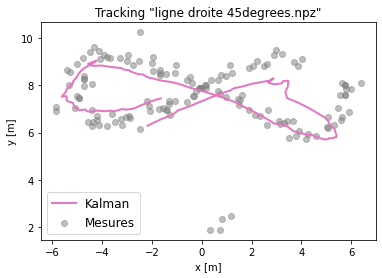

In [6]:
# Kalman Filter : ORDRE h (ici n)
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

n = 2 # Dév taylor ordre h 

phi_K = phi_r
d_K = np.zeros(N_frames)
v_K = np.zeros(N_frames)

n_cols = np.rot90(Matrix_corr_ifft_1[0],1).shape[1]

# Améliore ambiguité -> information suppplémentaire
for k in range(N_frames):
    M = np.rot90(Matrix_corr_ifft_1[k],1)
    max_index = np.argmax(M)
    i = max_index // n_cols
    j = max_index % n_cols
    d_K[k] = range_[j]
    v_K[k] = speed[i]

dt = (data_times[N_frames-1] - data_times[0])/N_frames # delta temps

# Paramètres de Kalman
dimx = 2*n        # x = [d, d', d'', phi, phi', phi'']
dimz = 3          # Mesures : [d, d', phi]

var_mes_d = 17.489556450000684
var_mes_v = 2                       #var_mes_d/dt
var_mes_phi = 0.1382062935964577

var_q_dpp =  0.01                   #var_mes_d/10
var_q_phipp = 0.01                  #var_mes_phi/10

f = KalmanFilter(dim_x=dimx, dim_z = dimz)

# x : Variables d'état
# f.x = np.zeros(dimx)
# Première estimation
f.x=np.zeros(dimx)
f.x[0]=d_K[0]
f.x[1]=v_K[0]
f.x[n]=phi_K[0]

Q=np.zeros((dimx,dimx))
Q[n-1][n-1]=var_q_dpp          #variance de la dernière variable de x : 3 -> variance accélération 10--> variance x(n)
Q[2*n-1][2*n-1]= var_q_phipp

# F : Matrice de transition d'état -> Taylor = MUA
F=np.zeros((dimx,dimx))
for k in range(2):
    for i in range(n):
        for j in range(i,n):
            F[k*n+i][k*n+j]=pow(dt,(j-i))/np.math.factorial((j-i))
f.F=F

# Q : Matrice du bruit des mesures
f.Q=F@Q@np.transpose(F)
#f.Q = np.zeros((dimx,dimx))

# H : Matrice d'observation
H=np.zeros((dimz,dimx))
H[0][0]=H[1][1]=H[2][n]=1
f.H=H

# R : Matrice de covariance de bruit des mesures (hyphothèse : covariance nulles, indépendantes)
f.R = np.array([
    [var_mes_d, 0,0],
    [0,var_mes_v,0],
    [0,0,var_mes_phi]
])

# P : Estimation de la matrice de covariance de l'état actuel
f.P *= 500
# Note : P init a np.eye() --- Première estimation probablement fausse donc haute incertitude

d_Kalman = np.zeros(N_frames)
v_Kalman = np.zeros(N_frames)
phi_Kalman = np.zeros(N_frames)

for fr in range(N_frames):
    # Mesures
    z = np.array([d_K[fr],v_K[fr],phi_K[fr]])
    f.predict()
    f.update(z)
    # Récupère les estimations
    d_Kalman[fr] = f.x[0]
    v_Kalman[fr] = f.x[1]
    phi_Kalman[fr] = f.x[n]

X_Kalman = np.zeros(N_frames)
Y_Kalman = np.zeros(N_frames)
X_mes = np.zeros(N_frames)
Y_mes = np.zeros(N_frames)
plt.figure()
for i in range(N_frames):
    X_Kalman[i] = d_Kalman[i]*np.cos(phi_Kalman[i])
    Y_Kalman[i] = d_Kalman[i]*np.sin(phi_Kalman[i])
    X_mes[i] = d_K[i]*np.cos(phi_K[i])
    Y_mes[i] = d_K[i]*np.sin(phi_K[i])

cutstart = 30
cutend = 30

plt.scatter(-X_mes[cutstart:-cutend],Y_mes[cutstart:-cutend], label="Mesures",color="grey",alpha=0.5)
plt.plot(-X_Kalman[cutstart:-cutend],Y_Kalman[cutstart:-cutend], color = "tab:pink", label = "Kalman", linewidth=2)
# plt.scatter(-X_Kalman[0],Y_Kalman[0], s=50, color = "tab:green" ,label = "Start (Kalman)")
# plt.scatter(-X_Kalman[-1],Y_Kalman[-1], s=50, color = "tab:red", label = "Stop(Kalman)")
plt.title("Tracking \"ligne droite 45degrees.npz\"")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.legend(loc="lower left",fontsize=12)
#plt.ylim(0,10)
a = max(max(-X_Kalman),max(-X_mes))
b = min(min(Y_Kalman),min(Y_mes))
# plt.text(a,b+1,r'$ \sigma_d^2 = {:.3f}$'.format(var_mes_d),verticalalignment='bottom', horizontalalignment='right',fontsize=12)
# plt.text(a,b,r'$ \sigma_ɸ^2 = {:.3f}$'.format(var_mes_phi),verticalalignment='bottom', horizontalalignment='right',fontsize=12)
# plt.savefig("droite h.pdf")
plt.show()

### Plots

In [7]:
# Fenêtre interactive matplotlib pour Jupyter Notebook
# Installer le module ipympl sur vos machines
# Anaconda Prompt : pip install ipympl
%matplotlib widget
number_frame = 5

if angle:
    plt.figure()
    plt.plot(phi_angle_r2, label = "Angle par rapport à la normale (ref2)")
    plt.xlabel("Frames")
    plt.ylabel("Estimation de l'angle - après calibration")
    plt.axhline(y = np.mean(phi_angle_r2), color = 'tab:orange', linestyle = '--',label="mean = {:.2f} (ref2)".format(np.mean(phi_angle_r2)))
    plt.title("Angle en fonction du temps (frame)")
    plt.legend()
    plt.show()

if sig:
    t = np.arange(len(data[0][0])-Mc*Nppause)
    frames = [] # for storing the generated images
    fig = plt.figure(figsize=(10,7))
    plt.plot(t,np.real(er1[number_frame]), label = "Composante en phase $I_1$")
    plt.plot(t,np.real(er2[number_frame]), label = "Composante en phase $I_2$")
    plt.plot(t,np.real( er2[number_frame]*np.exp(-1j * (k*rm*np.cos(np.mean(phi_r)) + calib) ) ), label = "Composante en phase $I_2$ après calibration")
    plt.legend()
    plt.show()
    
if imshow:
    fig = plt.figure(figsize=(10,7))
    extent = speed[0], speed[-1], range_[-1], range_[0]
    plt.imshow(Matrix_corr_ifft_1[number_frame],extent=extent,interpolation="Bessel",cmap = "plasma")
    plt.xlabel("v [m/s]")
    plt.ylabel("d [m]")
    plt.gca().invert_yaxis()
    plt.show()
    
vlim = 7.5
dlim = 15

if video:
    #Small video
    extent = speed[0], speed[-1], range_[-1], range_[0]
    #print(extent)
    frames = [] # for storing the generated images
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    for i in range(N_frames):
        # Angle affiché selon référence 2
        tlt = plt.text(0, 40, "Position detected at frame {}\nAngle = {}°".format(i, int(radToDeg(ref1Toref2(phi_r[i])))),
                       horizontalalignment='center', verticalalignment='bottom', color="white")
        
        ax.set_xlabel("v [m/s]")
        ax.set_ylabel("d [m]")
        #ax.set_xlim(-vlim,vlim)
        #ax.set_ylim(dlim,0)
        a = plt.imshow(Matrix_corr_ifft_1[i],extent=extent,interpolation="Bessel",cmap = "plasma")
        frames.append([a,tlt])
    #plt.colorbar() #pour avoir l'échelle mais osef
    ani = ArtistAnimation(fig, frames, interval=500, blit=True, repeat_delay=1000)
    plt.gca().invert_yaxis() #permet 0 en bas du graphique
    ani.save("Plots_TEST/movie_{}_2.gif".format(os.path.basename(file))) 
    #print("gif save") #pour sauvegarder
    plt.show()
    